In [1]:
import os
import numpy as np
import random
import copy
import pickle as pkl
import pandas as pd
import seaborn as sns
import random as rn 
import seaborn as sns

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.pyplot import *
from matplotlib.transforms import Affine2D
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 3
from pandas.api.types import CategoricalDtype

In [2]:
def results_vec_lr(attack, attack_list, filename2):
    
    sigma_factor = 2.0 #3-sigma=99.7% confidence, 2-sigma=95% confidence
    [df_results_original] = pkl.load(open(filename2,"rb") )

    strength_vec = np.unique(np.array(df_results_original['Perturbation_Strength']))

    x3_vec = []
    y3_vec_mean = []
    y3_vec_std = []
    for strength in strength_vec:
        df_0 = df_results_original[df_results_original['Perturbation_Strength']==strength]
        df_0 = df_0[df_0['Attack']==attack]

        x3_vec.append(strength)
        y3_vec_mean.append(np.mean(np.array(df_0['ACC'])))
        y3_vec_std.append(np.std(np.array(df_0['ACC'])))     

    y3_vec_upper = np.array(y3_vec_mean) + sigma_factor * np.array(y3_vec_std)
    y3_vec_lower = np.array(y3_vec_mean) - sigma_factor * np.array(y3_vec_std)
    y3_vec_mean = np.array(y3_vec_mean)    

    df_roi = df_results_original[df_results_original['Attack']==attack]
    df_roi["Perturbation"]=df_roi['Attack']

    return [x3_vec, y3_vec_upper, y3_vec_lower, y3_vec_mean, df_roi]

def results_vec_lr2(attack, attack_list, filename2):
    
    sigma_factor = 2.0 #3-sigma=99.7% confidence, 2-sigma=95% confidence
    df_results_original = pkl.load(open(filename2,"rb") )
    
    strength_vec = np.unique(np.array(df_results_original['Perturbation_Strength']))

    x3_vec = []
    y3_vec_mean = []
    y3_vec_std = []
    for strength in strength_vec:
        df_0 = df_results_original[df_results_original['Perturbation_Strength']==strength]
        df_0 = df_0[df_0['Perturbation_Test']==attack]

        x3_vec.append(strength)
        y3_vec_mean.append(np.mean(np.array(df_0['ACC'])))
        y3_vec_std.append(np.std(np.array(df_0['ACC'])))     

    y3_vec_upper = np.array(y3_vec_mean) + sigma_factor * np.array(y3_vec_std)
    y3_vec_lower = np.array(y3_vec_mean) - sigma_factor * np.array(y3_vec_std)
    y3_vec_mean = np.array(y3_vec_mean)    

    df_roi = df_results_original[df_results_original['Perturbation_Test']==attack]
    df_roi["Perturbation"]=df_roi['Perturbation_Test']

    return [x3_vec, y3_vec_upper, y3_vec_lower, y3_vec_mean, df_roi]

def results_vec(attack, attack_list, filename2):
    
    sigma_factor = 2.0 #3-sigma=99.7% confidence, 2-sigma=95% confidence
    df_results_original = pd.DataFrame()
    
    counter=0
    for fold in range(0,10):
        filename = filename2+attack+"_"+str(fold)+".pkl"    
        if os.path.isfile(filename): 
            [df_results_original_tmp] = pkl.load(open(filename,"rb") )
            if counter>0:
                df_results_original=df_results_original.append(df_results_original_tmp)
            else:
                df_results_original=df_results_original_tmp
            counter = counter +1

    if counter > 0:
        
        strength_vec = np.unique(np.array(df_results_original['Perturbation_Strength']))
        x3_vec = []
        y3_vec_mean = []
        y3_vec_std = []
        for strength in strength_vec:
            df_0 = df_results_original[df_results_original['Perturbation_Strength']==strength]
            df_0 = df_0[df_0['Perturbation']==attack]
            x3_vec.append(strength)
            y3_vec_mean.append(np.mean(np.array(df_0['ACC'])))
            y3_vec_std.append(np.std(np.array(df_0['ACC'])))     

        y3_vec_upper = np.array(y3_vec_mean) + sigma_factor * np.array(y3_vec_std)
        y3_vec_lower = np.array(y3_vec_mean) - sigma_factor * np.array(y3_vec_std)
        y3_vec_mean = np.array(y3_vec_mean)    

        return [x3_vec, y3_vec_upper, y3_vec_lower, y3_vec_mean, df_results_original]
    
    else:
        return [[], [],[],[], []]    
    
def return_area_dataframe(tr128_df,attack,modelname):
    df_integral=pd.DataFrame({"label":[], "attack":[], "seed":[], "sample":[], "region":[], "mean integrated robustness":[]})

    low_region=[0,33.3]
    med_region=[33.3,66.6]
    high_region=[66.6,99.9]
    fidelity = 10
    x_vec_interpol =  np.arange(100*fidelity)/fidelity

    for seed in range(0,10):
        for sample in range(0,10):
            tr128_roi=tr128_df[tr128_df["Random_Seed"]==seed] 
            tr128_roi=tr128_roi[tr128_roi["Sample"]==sample]
            tr128_roi2=tr128_roi[tr128_roi["Perturbation"]==attack]

            x_vec = tr128_roi2["Perturbation_Strength"].values
            y_vec = tr128_roi2["ACC"].values

            if len(x_vec)>0:
                y_vec_interpol = [np.interp(i/fidelity, x_vec, y_vec) for i in range(len(x_vec_interpol))]

                roi_vec = np.where((x_vec_interpol>low_region[0]) & (x_vec_interpol<=low_region[1]))[0]
                dx = x_vec_interpol[1]-x_vec_interpol[0]
                low=np.sum(np.array(y_vec_interpol)[roi_vec])*dx
                df_integral = df_integral.append(pd.DataFrame({"label":[modelname], "attack":[attack],"seed":[seed], "sample":[sample], "region":["low"], "mean integrated robustness":[low]}))

                roi_vec = np.where((x_vec_interpol>med_region[0]) & (x_vec_interpol<=med_region[1]))[0]
                dx = x_vec_interpol[1]-x_vec_interpol[0]
                med=np.sum(np.array(y_vec_interpol)[roi_vec])*dx
                df_integral = df_integral.append(pd.DataFrame({"label":[modelname], "attack":[attack],"seed":[seed], "sample":[sample], "region":["medium"], "mean integrated robustness":[med]}))

                roi_vec = np.where((x_vec_interpol>high_region[0]) & (x_vec_interpol<=high_region[1]))[0]
                dx = x_vec_interpol[1]-x_vec_interpol[0]
                high=np.sum(np.array(y_vec_interpol)[roi_vec])*dx
                df_integral = df_integral.append(pd.DataFrame({"label":[modelname], "attack":[attack],"seed":[seed], "sample":[sample], "region":["high"], "mean integrated robustness":[high]}))

    return df_integral    

In [3]:
path = "plots/"
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)
    
path2 = path+ "Fig4/"
try:
    os.mkdir(path2)
except OSError:
    print ("Creation of the directory %s failed" % path2)
else:
    print ("Successfully created the directory %s " % path2)
    
path3 = path2+ "eps/"
try:
    os.mkdir(path3)
except OSError:
    print ("Creation of the directory %s failed" % path3)
else:
    print ("Successfully created the directory %s " % path3)
    
path4 = path2+ "png/"
try:
    os.mkdir(path4)
except OSError:
    print ("Creation of the directory %s failed" % path4)
else:
    print ("Successfully created the directory %s " % path4)

Creation of the directory plots/ failed
Successfully created the directory plots/Fig4/ 
Successfully created the directory plots/Fig4/eps/ 
Successfully created the directory plots/Fig4/png/ 


In [4]:
attack_lst = ["NeighborKeyboard", "HomoPhones", "SimilarSymbols", ]
dataset_lst = ["YelpPolarity","AgNews", "DbPedia"]
sample_lst = [[5, 5, 5, 5],[10, 10, 5, 10],[5,5,5,5]]
epoch_lst = [[5, 40, 20, 20], [20, 20, 20, 50], [10, 20, 20, 20]]
transformer1024_epochs=[40, 50, 30, 20]
text_table_latex=""
df_latex_table=pd.DataFrame()
df_latex_table_early=pd.DataFrame()
colors = ['#4c72b0', '#dd8452', '#55a868', '#8172b3', '#937860']
font_size = 75
marker_size = 12
alpha_value = 0.3
cap_thick = 2
line_width=1.5
bar_width = 0.15
epsilon = .025 #.025
line_width = 2
opacity = 1.0
opacity2 = 1
cap = 10
cap2 = 10
sigma_factor = 2.0

segments = ['low', 'medium', 'high']
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
sns.set_theme(style="whitegrid")
figure_lst = ["a", "b", "c"]
my_dpi = 300

YelpPolarity
attack   :NeighborKeyboard
NeighborKeyboard
AgNews
attack   :HomoPhones
HomoPhones
DbPedia
attack   :SimilarSymbols
SimilarSymbols


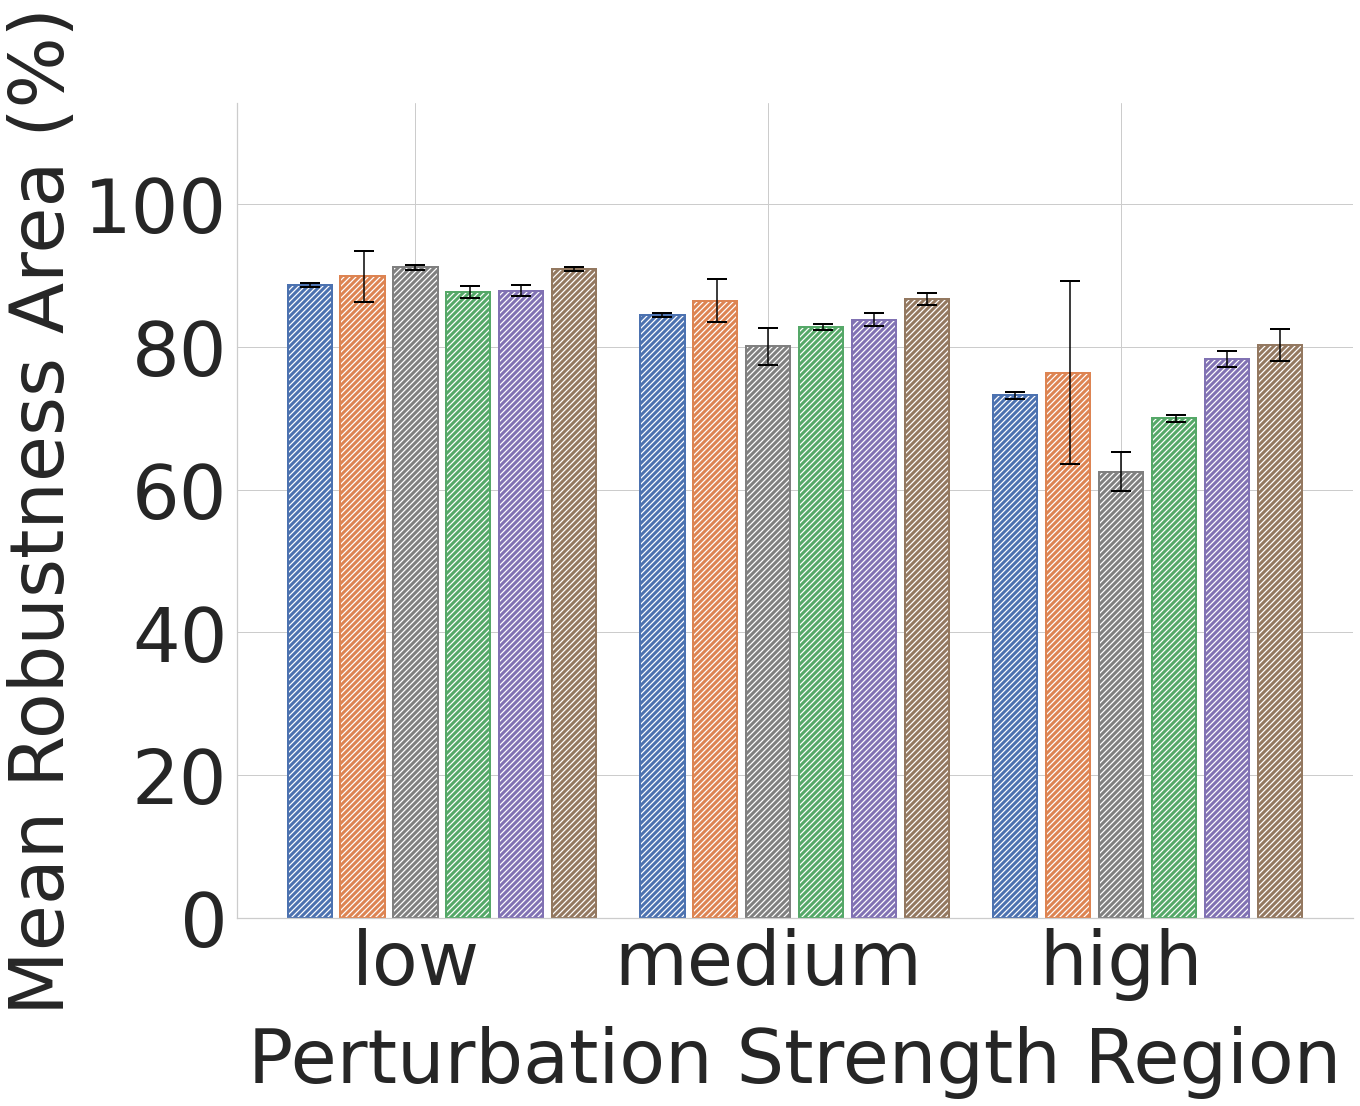

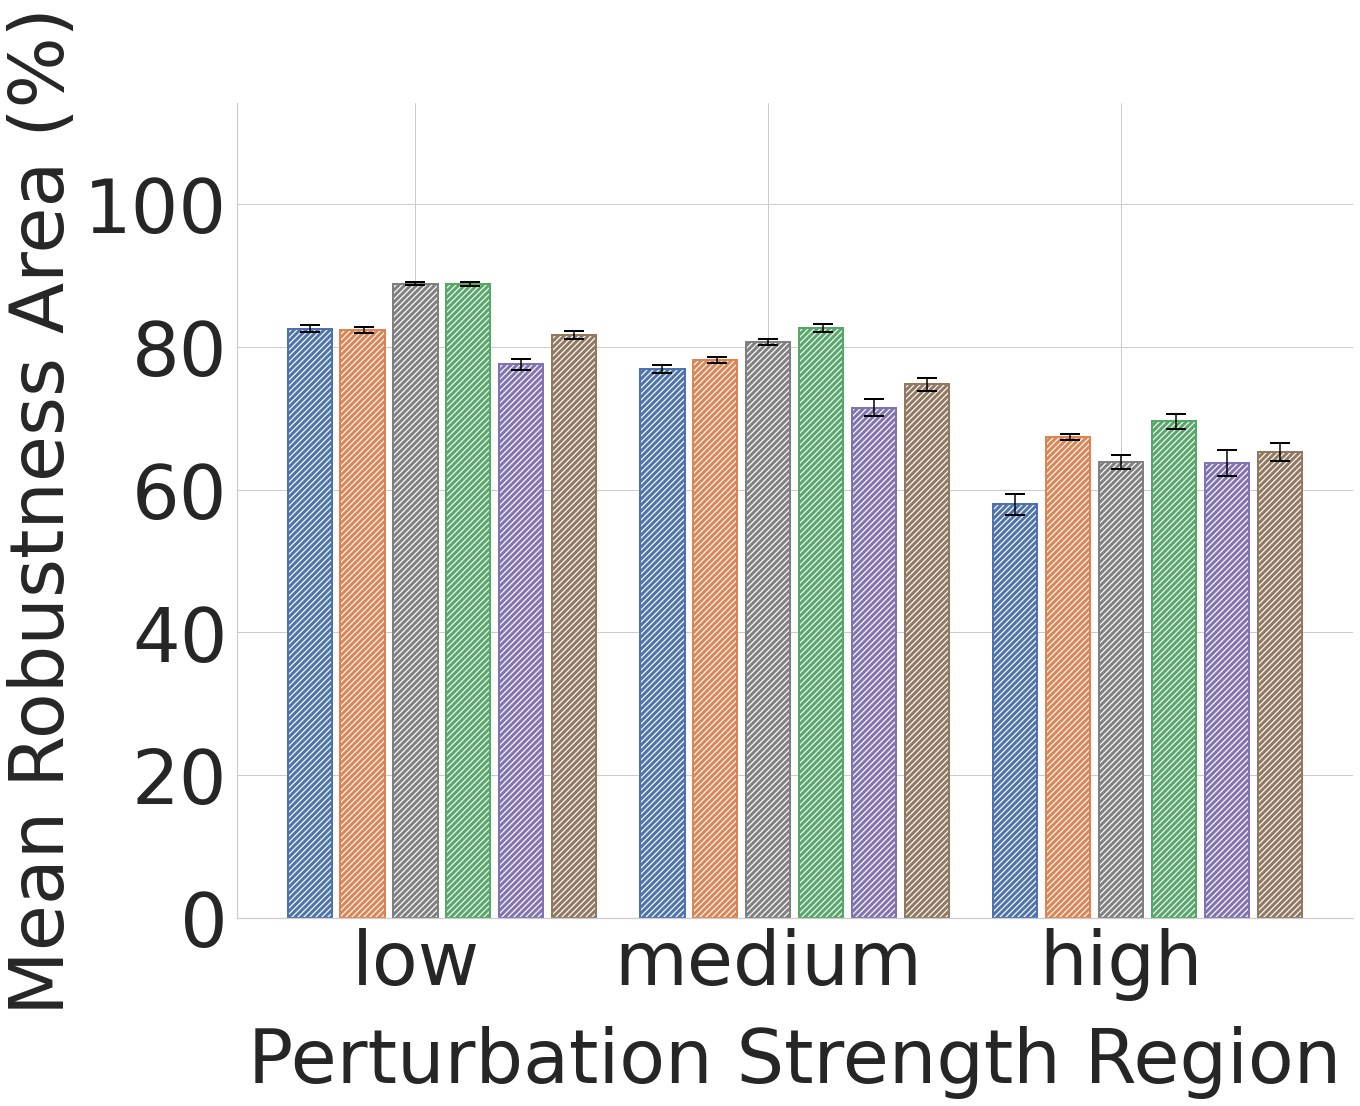

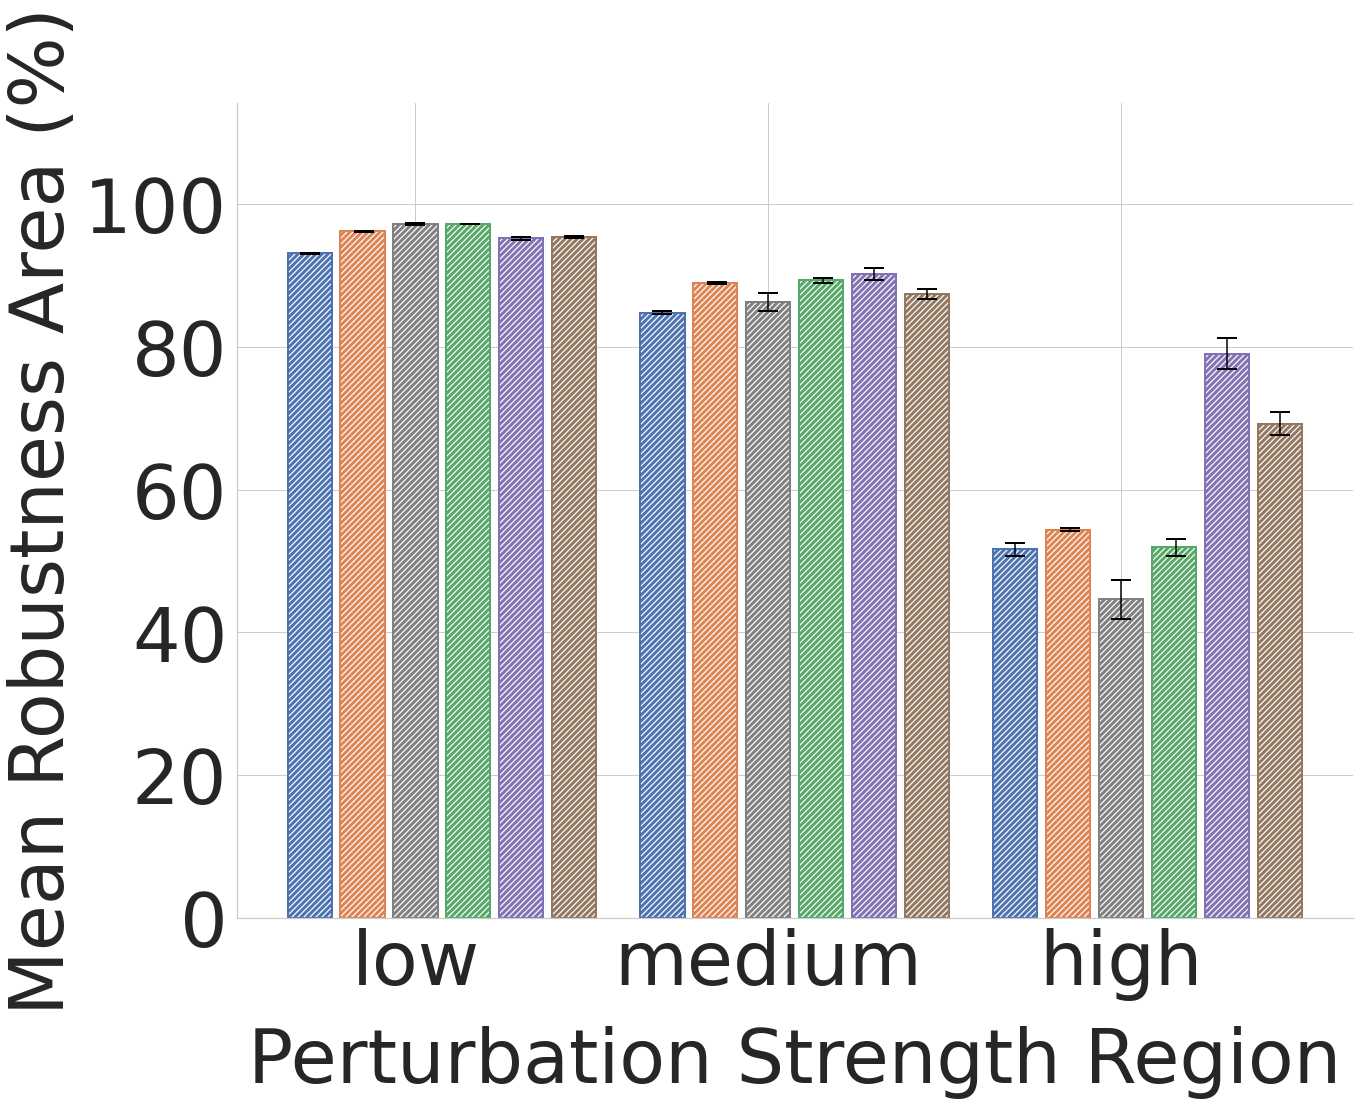

In [5]:
for idx in range(3):
    dataset_idx = idx
    attack_idx = idx

    dataset = dataset_lst[dataset_idx]
    print(dataset)

    attack = attack_lst[attack_idx]
    print("attack   :"+attack)

    print(attack)
    filename = "results_unperturbed/df_results_lr_"+dataset.lower()+".pkl"
    [lr_vec, lr_vec_upper, lr_vec_lower, lr_vec_mean, lr_df] = results_vec_lr(attack, attack_lst, filename)

    filename = "results_unperturbed/results_unperturbed_svm_" + dataset + ".pkl"
    [svm_vec, svm_vec_upper, svm_vec_lower, svm_vec_mean, svm_df] = results_vec_lr(attack, attack_lst, filename)

    filename="results_unperturbed/perturbation_curve_samples_"+str(sample_lst[dataset_idx][0])+"_Transformer(128)_epoch_"+str(epoch_lst[dataset_idx][0])+"_"+dataset+"_"
    [tr128_vec, tr128_vec_upper, tr128_vec_lower, tr128_vec_mean, tr128_df] = results_vec(attack, attack_lst, filename)

    epoch = epoch_lst[dataset_idx][1]
    filename="results_unperturbed/perturbation_curve_samples_"+str(sample_lst[dataset_idx][1])+"_Transformer(1024)_epoch_"+str(epoch)+"_"+dataset+"_"
    [tr1024_vec, tr1024_vec_upper, tr1024_vec_lower, tr1024_vec_mean, tr1024_df] = results_vec(attack, attack_lst, filename)

    filename="results_unperturbed/perturbation_curve_samples_"+str(sample_lst[dataset_idx][2])+"_VDCNN(9)_epoch_"+str(epoch_lst[dataset_idx][2])+"_"+dataset+"_"
    [cnn9_vec, cnn9_vec_upper, cnn9_vec_lower, cnn9_vec_mean, cnn9_df] = results_vec(attack, attack_lst, filename)

    filename="results_unperturbed/perturbation_curve_samples_"+str(sample_lst[dataset_idx][3])+"_VDCNN(49)_epoch_"+str(epoch_lst[dataset_idx][3])+"_"+dataset+"_"
    [cnn49_vec, cnn49_vec_upper, cnn49_vec_lower, cnn49_vec_mean, cnn49_df] = results_vec(attack, attack_lst, filename)

    vec=[]
    if len(lr_vec_mean)>0:
        vec.append("$"+str(np.round(lr_vec_mean[0]*100,2))+" \pm "+str(np.round(lr_vec_mean[0]*100-lr_vec_lower[0]*100,2))+"$")
    else:
        vec.append("$"+str("???")+" \pm "+str("???")+"$")
    if len(cnn9_vec_mean)>0:
        vec.append("$ "+str(np.round(cnn9_vec_mean[0]*100,2))+" \pm "+str(np.round(cnn9_vec_mean[0]*100-cnn9_vec_lower[0]*100,2))+"$")
    else:
        vec.append("$"+str("???")+" \pm "+str("???")+"$")
    if len(cnn49_vec_mean)>0:
        vec.append("$ "+str(np.round(cnn49_vec_mean[0]*100,2))+" \pm "+str(np.round(cnn49_vec_mean[0]*100-cnn49_vec_lower[0]*100,2))+"$")
    else:
        vec.append("$"+str("???")+" \pm "+str("???")+"$")
    if len(tr128_vec_mean)>0:
        vec.append("$ "+str(np.round(tr128_vec_mean[0]*100,2))+" \pm "+str(np.round(tr128_vec_mean[0]*100-tr128_vec_lower[0]*100,2))+"$")
    else:
        vec.append("$"+str("???")+" \pm "+str("???")+"$")

    if len(tr1024_vec_mean)>0:
        vec.append("$ "+str(np.round(tr1024_vec_mean[0]*100,2))+" \pm "+str(np.round(tr128_vec_mean[0]*100-tr1024_vec_lower[0]*100,2))+"$")
    else:
        vec.append("$ "+str("???")+" \pm "+str("???")+"$")

    df_latex_table['Model'] = ['\text{LR}','\text{CNN9}','\text{CNN49}','\text{TR128}','\text{TR1024}']
    df_latex_table[dataset] = vec

    vec=[str("???"),str(epoch_lst[dataset_idx][2]),str(epoch_lst[dataset_idx][3]),str(epoch_lst[dataset_idx][0]),str(epoch_lst[dataset_idx][1])]
    df_latex_table_early['Model'] = ['\text{LR}','\text{CNN9}','\text{CNN49}','\text{TR128}','\text{TR1024}']
    df_latex_table_early[dataset] = vec

    plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})

    df_integral_lr = return_area_dataframe(lr_df,attack,"LR")
    df_integral_svm = return_area_dataframe(svm_df,attack,"LR")

    df_integral_tr128 = return_area_dataframe(tr128_df,attack,"TR(128)")
    df_integral_tr1024 = return_area_dataframe(tr1024_df,attack,"TR(1024)")

    df_integral_cnn9 = return_area_dataframe(cnn9_df,attack,"VDCNN(9)")
    df_integral_cnn49 = return_area_dataframe(cnn49_df,attack,"VDCNN(49)")

    df_integral_all = df_integral_lr.append(df_integral_svm).append(df_integral_tr128).append(df_integral_tr1024).append(df_integral_cnn9).append(df_integral_cnn49)
    df_integral_all = df_integral_all.reset_index().drop("index",axis=1)

    ###############################################################################################################
    df_integral_lr['mean integrated robustness'] = df_integral_lr['mean integrated robustness']/33.3*100
    df_integral_svm['mean integrated robustness'] = df_integral_svm['mean integrated robustness']/33.3*100    
    df_integral_tr128['mean integrated robustness'] = df_integral_tr128['mean integrated robustness']/33.3*100
    df_integral_tr1024['mean integrated robustness'] = df_integral_tr1024['mean integrated robustness']/33.3*100
    df_integral_cnn9['mean integrated robustness'] = df_integral_cnn9['mean integrated robustness']/33.3*100
    df_integral_cnn49['mean integrated robustness'] = df_integral_cnn49['mean integrated robustness']/33.3*100
    ##############################################################################################################

    cat_seg = CategoricalDtype(
        ['low', 'medium', 'high'], 
        ordered=True
    )
    cat_model = CategoricalDtype(
        ['LR', 'SVM', 'TR(128)','TR(1024)', 'VDCNN(9)','VDCNN(49)',], 
        ordered=True,
    )

    dfCopy = df_integral_all
    dfCopy['region'] = dfCopy['region'].astype(cat_seg)
    dfCopy['label'] = dfCopy['label'].astype(cat_model)
    dfCopy = dfCopy.sort_values(['region', 'label'])

    ##############################################################################################################

    lr_unperturbed=[]
    lr_unperturbed.append(np.mean(df_integral_lr[df_integral_lr['region']=='low']['mean integrated robustness'].values))
    lr_unperturbed.append(np.mean(df_integral_lr[df_integral_lr['region']=='medium']['mean integrated robustness'].values))
    lr_unperturbed.append(np.mean(df_integral_lr[df_integral_lr['region']=='high']['mean integrated robustness'].values))
    error_lr_unperturbed=[]
    error_lr_unperturbed.append(sigma_factor*np.std(df_integral_lr[df_integral_lr['region']=='low']['mean integrated robustness'].values))
    error_lr_unperturbed.append(sigma_factor*np.std(df_integral_lr[df_integral_lr['region']=='medium']['mean integrated robustness'].values))
    error_lr_unperturbed.append(sigma_factor*np.std(df_integral_lr[df_integral_lr['region']=='high']['mean integrated robustness'].values))

    ##############################################################################################################

    svm_unperturbed=[]
    svm_unperturbed.append(np.mean(df_integral_svm[df_integral_svm['region']=='low']['mean integrated robustness'].values))
    svm_unperturbed.append(np.mean(df_integral_svm[df_integral_svm['region']=='medium']['mean integrated robustness'].values))
    svm_unperturbed.append(np.mean(df_integral_svm[df_integral_svm['region']=='high']['mean integrated robustness'].values))
    error_svm_unperturbed=[]
    error_svm_unperturbed.append(sigma_factor*np.std(df_integral_svm[df_integral_svm['region']=='low']['mean integrated robustness'].values))
    error_svm_unperturbed.append(sigma_factor*np.std(df_integral_svm[df_integral_svm['region']=='medium']['mean integrated robustness'].values))
    error_svm_unperturbed.append(sigma_factor*np.std(df_integral_svm[df_integral_svm['region']=='high']['mean integrated robustness'].values))

    tr128_unperturbed=[]
    tr128_unperturbed.append(np.mean(df_integral_tr128[df_integral_tr128['region']=='low']['mean integrated robustness'].values))
    tr128_unperturbed.append(np.mean(df_integral_tr128[df_integral_tr128['region']=='medium']['mean integrated robustness'].values))
    tr128_unperturbed.append(np.mean(df_integral_tr128[df_integral_tr128['region']=='high']['mean integrated robustness'].values))
    error_tr128_unperturbed=[]
    error_tr128_unperturbed.append(np.std(df_integral_tr128[df_integral_tr128['region']=='low']['mean integrated robustness'].values))
    error_tr128_unperturbed.append(np.std(df_integral_tr128[df_integral_tr128['region']=='medium']['mean integrated robustness'].values))
    error_tr128_unperturbed.append(np.std(df_integral_tr128[df_integral_tr128['region']=='high']['mean integrated robustness'].values))

    ##############################################################################################################

    tr1024_unperturbed=[]
    tr1024_unperturbed.append(np.mean(df_integral_tr1024[df_integral_tr1024['region']=='low']['mean integrated robustness'].values))
    tr1024_unperturbed.append(np.mean(df_integral_tr1024[df_integral_tr1024['region']=='medium']['mean integrated robustness'].values))
    tr1024_unperturbed.append(np.mean(df_integral_tr1024[df_integral_tr1024['region']=='high']['mean integrated robustness'].values))
    error_tr1024_unperturbed=[]
    error_tr1024_unperturbed.append(np.std(df_integral_tr1024[df_integral_tr1024['region']=='low']['mean integrated robustness'].values))
    error_tr1024_unperturbed.append(np.std(df_integral_tr1024[df_integral_tr1024['region']=='medium']['mean integrated robustness'].values))
    error_tr1024_unperturbed.append(np.std(df_integral_tr1024[df_integral_tr1024['region']=='high']['mean integrated robustness'].values))

    #################################################################################################################

    cnn9_unperturbed=[]
    cnn9_unperturbed.append(np.mean(df_integral_cnn9[df_integral_cnn9['region']=='low']['mean integrated robustness'].values))
    cnn9_unperturbed.append(np.mean(df_integral_cnn9[df_integral_cnn9['region']=='medium']['mean integrated robustness'].values))
    cnn9_unperturbed.append(np.mean(df_integral_cnn9[df_integral_cnn9['region']=='high']['mean integrated robustness'].values))
    error_cnn9_unperturbed=[]
    error_cnn9_unperturbed.append(np.std(df_integral_cnn9[df_integral_cnn9['region']=='low']['mean integrated robustness'].values))
    error_cnn9_unperturbed.append(np.std(df_integral_cnn9[df_integral_cnn9['region']=='medium']['mean integrated robustness'].values))
    error_cnn9_unperturbed.append(np.std(df_integral_cnn9[df_integral_cnn9['region']=='high']['mean integrated robustness'].values))

    #################################################################################################################

    cnn49_unperturbed=[]
    cnn49_unperturbed.append(np.mean(df_integral_cnn49[df_integral_cnn49['region']=='low']['mean integrated robustness'].values))
    cnn49_unperturbed.append(np.mean(df_integral_cnn49[df_integral_cnn49['region']=='medium']['mean integrated robustness'].values))
    cnn49_unperturbed.append(np.mean(df_integral_cnn49[df_integral_cnn49['region']=='high']['mean integrated robustness'].values))
    error_cnn49_unperturbed=[]
    error_cnn49_unperturbed.append(np.std(df_integral_cnn49[df_integral_cnn49['region']=='low']['mean integrated robustness'].values))
    error_cnn49_unperturbed.append(np.std(df_integral_cnn49[df_integral_cnn49['region']=='medium']['mean integrated robustness'].values))
    error_cnn49_unperturbed.append(np.std(df_integral_cnn49[df_integral_cnn49['region']=='high']['mean integrated robustness'].values))

    #################################################################################################################
    ax = plt.figure(figsize=(20,15))

    first_bar_positions = np.arange(len(lr_unperturbed))
    second_bar_positions = first_bar_positions + bar_width
    third_bar_positions = first_bar_positions + 2*bar_width
    forth_bar_positions = first_bar_positions + 3*bar_width
    fifth_bar_positions = first_bar_positions + 4*bar_width
    sixth_bar_positions = first_bar_positions + 5*bar_width

    ################################################################################################################
    # make bar plots

    lr_unperturbed_bar = plt.bar(first_bar_positions, lr_unperturbed, bar_width-epsilon,
                               ecolor='red', capsize=cap2,
                              alpha=opacity,
                              color='white',
                              edgecolor='#4c72b0',
                              linewidth=line_width,
                              hatch='////',
                              label='LR unperturbed')

    plt.errorbar(0.0, lr_unperturbed[0], yerr=error_lr_unperturbed[0], capsize=cap, color = "black", 
                 capthick = cap_thick)
    plt.errorbar(1.0, lr_unperturbed[1], yerr=error_lr_unperturbed[1], capsize=cap, color = "black", capthick = cap_thick)
    plt.errorbar(2.0, lr_unperturbed[2], yerr=error_lr_unperturbed[2], capsize=cap, color = "black", capthick = cap_thick)

    ##################################################################################################################
    svm_unperturbed_bar = plt.bar(second_bar_positions, svm_unperturbed, bar_width-epsilon,
                               ecolor='red', capsize=cap2,
                              alpha=opacity,
                              color='white',
                              edgecolor='#dd8452',
                              linewidth=line_width,
                              hatch='////',
                              label='SVM unperturbed')

    plt.errorbar(0.155, svm_unperturbed[0], yerr=error_svm_unperturbed[0], capsize=cap, color = "black", 
                 capthick = cap_thick)
    plt.errorbar(1.155, svm_unperturbed[1], yerr=error_svm_unperturbed[1], capsize=cap, color = "black", capthick = cap_thick)
    plt.errorbar(2.155, svm_unperturbed[2], yerr=error_svm_unperturbed[2], capsize=cap, color = "black", capthick = cap_thick)

    ##################################################################################################################

    tr128_unperturbed_bar = plt.bar(third_bar_positions, tr128_unperturbed, bar_width-epsilon, 
                                  ecolor='red',
                                  capsize=cap2,
                                  alpha=opacity,
                                  color='white',
                                  edgecolor='grey',
                                  linewidth=line_width,
                                  hatch='////',
                                  label='TR(128) unperturbed')


    plt.errorbar(0.3, tr128_unperturbed[0], yerr=error_tr128_unperturbed[0], capsize=cap, color = "black", 
                 capthick = cap_thick)
    plt.errorbar(1.3, tr128_unperturbed[1], yerr=error_tr128_unperturbed[1], capsize=cap, color = "black", capthick = cap_thick)
    plt.errorbar(2.3, tr128_unperturbed[2], yerr=error_tr128_unperturbed[2], capsize=cap, color = "black", capthick = cap_thick)


    ##################################################################################################################


    tr1024_unperturbed_bar = plt.bar(forth_bar_positions, tr1024_unperturbed, bar_width-epsilon, 
                              ecolor='red',
                              capsize=cap2,
                              alpha=opacity,
                              color='white',
                              edgecolor='#55a868',
                              linewidth=line_width,
                              hatch='////',
                              label='TR(1024) unperturbed')

    plt.errorbar(0.455, tr1024_unperturbed[0], yerr=error_tr1024_unperturbed[0], capsize=cap, color = "black", 
                 capthick = cap_thick)
    plt.errorbar(1.455, tr1024_unperturbed[1], yerr=error_tr1024_unperturbed[1], capsize=cap, color = "black", capthick = cap_thick)
    plt.errorbar(2.455, tr1024_unperturbed[2], yerr=error_tr1024_unperturbed[2], capsize=cap, color = "black", capthick = cap_thick)



    #################################################################################################################


    cnn9_unperturbed_bar = plt.bar(fifth_bar_positions, cnn9_unperturbed, bar_width-epsilon,
                              ecolor='red',
                              capsize=cap2,
                              alpha=opacity,
                              color='white',
                              edgecolor='#8172b3',
                              linewidth=line_width,
                              hatch='////',
                              label='VDCNN(9) unperturbed')

    plt.errorbar(0.6, cnn9_unperturbed[0], yerr=error_cnn9_unperturbed[0], 
                 capsize=cap, color = "black", capthick = cap_thick)

    plt.errorbar(1.6, cnn9_unperturbed[1], yerr=error_cnn9_unperturbed[1], capsize=cap, 
                 color = "black", capthick = cap_thick)

    plt.errorbar(2.6, cnn9_unperturbed[2], yerr=error_cnn9_unperturbed[2], 
                 capsize=cap, color = "black", capthick = cap_thick)

    ################################################################################################################


    cnn49_unperturbed_bar = plt.bar(sixth_bar_positions, cnn49_unperturbed, bar_width-epsilon, 
                              ecolor='red',
                              alpha=opacity,
                              color='white',
                              edgecolor='#937860',
                              linewidth=line_width,
                              hatch='////',
                              label='VDCNN(49) unperturbed')
    plt.errorbar(0.75, cnn49_unperturbed[0], yerr=error_cnn49_unperturbed[0], color = "black",capsize=cap, capthick = cap_thick)
    plt.errorbar(1.75, cnn49_unperturbed[1], yerr=error_cnn49_unperturbed[1], color = "black",capsize=cap, capthick = cap_thick)
    plt.errorbar(2.75, cnn49_unperturbed[2], yerr=error_cnn49_unperturbed[2], color = "black",capsize=cap, capthick = cap_thick)

    categories = ["perturbed"]

    p5, = plot([0], marker='None',
               linestyle='None', label='dummy-tophead')

    plt.xticks(third_bar_positions, segments, fontsize = font_size)
    plt.ylabel('Mean Robustness Area (%)', fontsize = font_size)
    plt.xlabel('Perturbation Strength Region', fontsize = font_size, labelpad=25)
    plt.yticks(fontsize = font_size)
    plt.ylim([0, 38/33.3*100])

    sns.despine()
    ax.set_rasterized(True)

    filename = path3 + figure_lst[idx] + "_unperturbed_"+attack+"_robustness_analysis_segments_"+dataset+".eps"
    plt.savefig(filename, format='eps', bbox_inches="tight")
    filename = path4 + figure_lst[idx] + "_unperturbed_"+attack+"_robustness_analysis_segments_"+dataset+".png"
    plt.savefig(filename, dpi = my_dpi, bbox_inches="tight")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


plots/Fig4/eps//unperturbed_legend.eps
plots/Fig4/png//unperturbed_legend.png


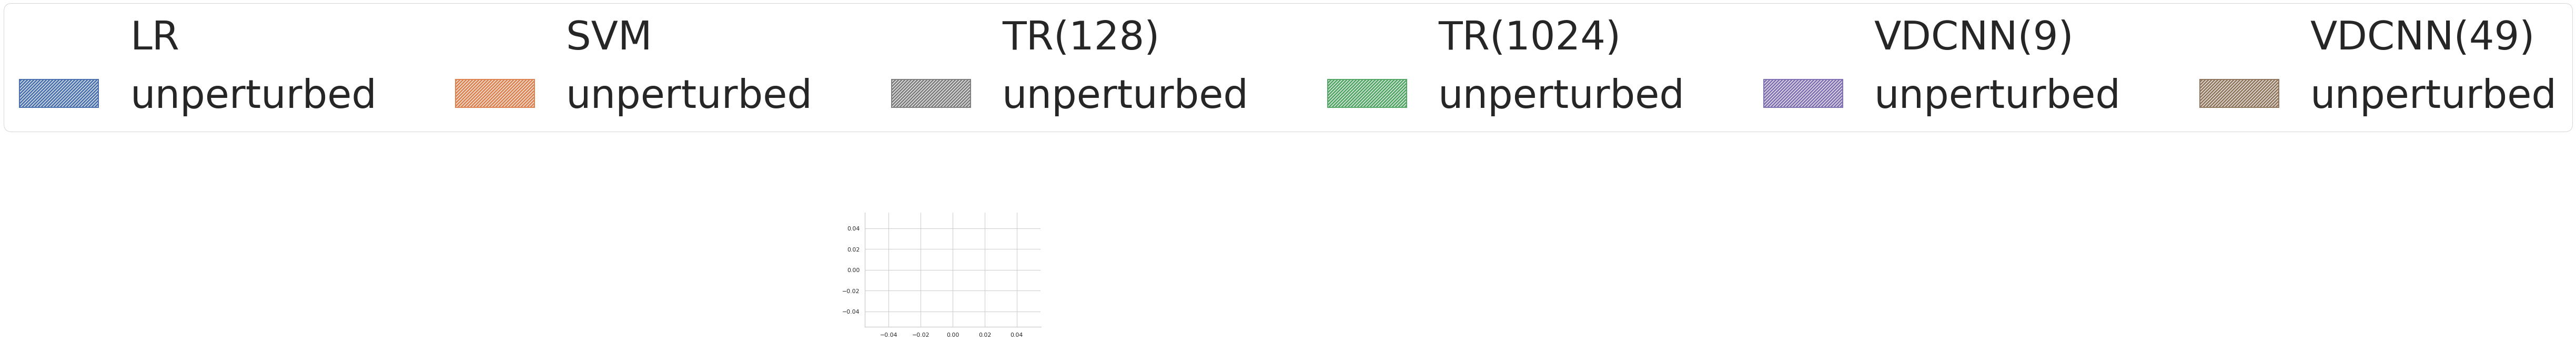

In [6]:
categories = ["unperturbed"]

p5, = plot([0], marker='None',
           linestyle='None', label='dummy-tophead')

leg3 = legend([p5, lr_unperturbed_bar, 
               p5, svm_unperturbed_bar, 
               p5, tr128_unperturbed_bar,
              p5, tr1024_unperturbed_bar,
               p5, cnn9_unperturbed_bar,
              p5, cnn49_unperturbed_bar],
              ['LR'] + categories + ['SVM'] + categories + ['TR(128)'] + categories + ['TR(1024)'] + categories + ['VDCNN(9)'] + categories + ['VDCNN(49)'] + categories,
              loc=2, ncol=6, fontsize = font_size, bbox_to_anchor=(-5,3)) # Two columns, vertical group labels
ax.set_rasterized(True)

filename = path3 + "/unperturbed_legend.eps"
print(filename)
plt.savefig(filename,  bbox_inches='tight', format = "eps")

filename = path4 + "/unperturbed_legend.png"
print(filename)
plt.savefig(filename,  bbox_inches='tight', dpi = my_dpi)
